In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, EstimatorV2, EstimatorOptions
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import ising_disorder_circuit as circuits
import matplotlib.pyplot as plt
from cobos.token import ibm_token
from utils import hexec
import numpy as np
import itertools

plt.rc("text", usetex=True)
plt.rc("font", family="serif", size=28, weight="bold")

## Credentials

In [2]:
channel = "ibm_quantum"
token = ibm_token

service = QiskitRuntimeService(channel=channel, token=token)

## Device selection

In [3]:
device = "ibm_torino"
optimization_level = 3
backend = service.get_backend(device)
pm = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend)

## Layout

In [4]:
# qubits_inds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16,
#                26, 27, 28, 29, 30, 31, 32, 36, 51, 50,
#                49, 48, 47, 46, 45, 44, 43, 42, 41, 53,
#                60, 61, 62, 72, 81, 80, 79, 78, 77, 76,
#                75, 90, 94, 95, 96, 97, 98, 99, 100, 101,
#                102, 92, 83, 84, 85, 86, 87, 93, 106, 107, 
#                108, 112, 126, 125] #Shebrokee

# qubits_inds = [13, 12, 11, 10, 9, 8, 7, 6, 5, 4,
#                3, 2, 1, 0, 14, 18, 19, 20, 33, 39, 
#                38, 37, 52, 56, 57, 58, 59, 60, 53, 41,
#                42, 43, 44, 45, 54, 64, 65, 66, 67, 68,
#                69, 70, 74, 89, 88, 87, 86, 85, 84, 83,
#                92, 102, 103, 104, 111, 122, 121, 120, 119, 118,
#                117, 116, 115, 114] #Kyiv

### Parameters

In [5]:
seed = 0
disorder_parameter = 0.3
nqubits_arr = 2**np.arange(2, 7)
twoqdepth_arr = 2**np.arange(2, 7)
params_arr = list(itertools.product(nqubits_arr, twoqdepth_arr))
pm = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend)

### Circuits

In [9]:
logical_circuits_arr = [circuits.cunc_example_circuit(nqubits, twoqdepth, seed, disorder_parameter) for nqubits, twoqdepth in params_arr]
physical_circuits_arr = [pm.run(circuit) for circuit in logical_circuits_arr]

In [ ]:
logical_circuits_arr = [circuits.cunc_example_circuit(nqubits, twoqdepth, seed, disorder_parameter) for nqubits, twoqdepth in params_arr]
physical_circuits_arr = []
for i, nqubits in enumerate(nqubits_arr):
    pm = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend, initial_layout=qubits_inds[:nqubits])
    for j, twoqdepth in enumerate(twoqdepth_arr):
        physical_circuits_arr.append(pm.run(logical_circuits_arr[i*len(twoqdepth_arr)+j]))

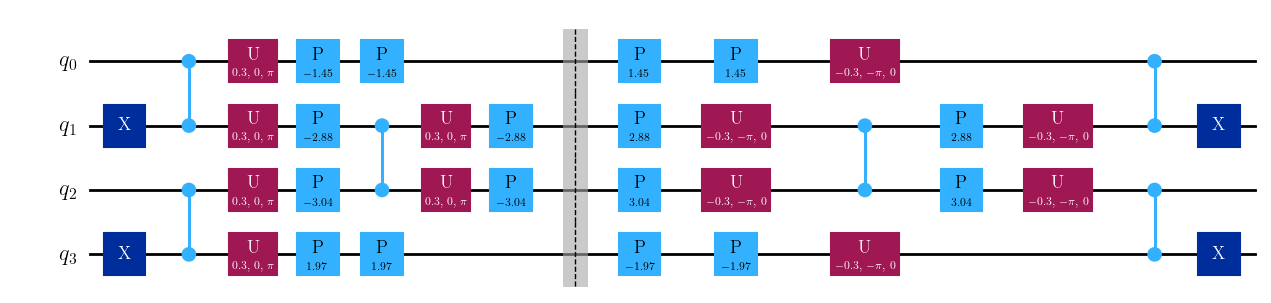

In [ ]:
logical_circuits_arr[0].draw(output="mpl", fold=-1)

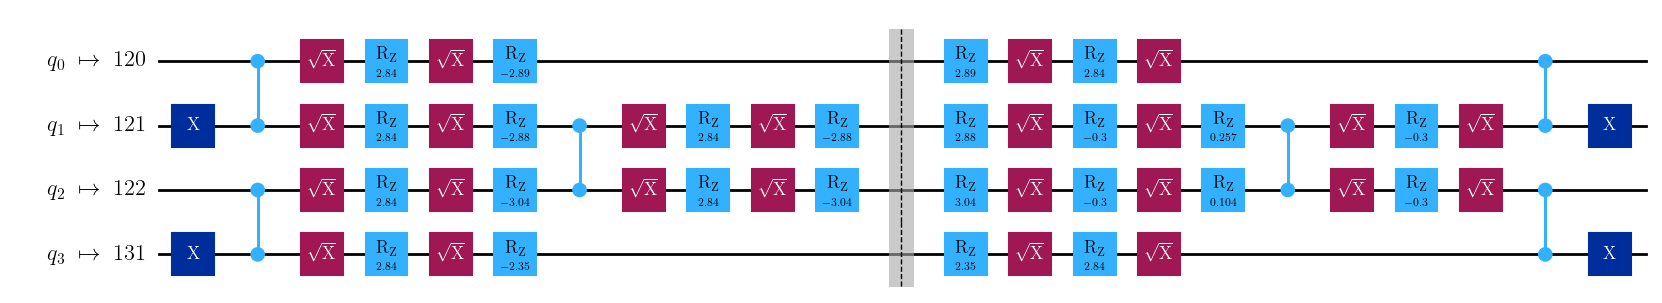

In [ ]:
physical_circuits_arr[0].draw(output="mpl", fold=-1, idle_wires=False)

## Circuit execution

In [10]:
default_shots = 4096
optimization_level = 0 # Deactivate error suppression
resilience_level = 0 # Deactivate error mitigation
execution_database = "single_run_experiments.json"
zne_mitigation = "none"
measure_mitigation = True
run = 1

zne_mitigation_dict = {"none": "",
                       "linear": r"linear",
                       "quadratic": r'polynomial_degree_2',
                       "exponential": r"exponential"}

estimatior_options = {
    "default_shots": default_shots,
    "optimization_level": optimization_level,
    "resilience_level": resilience_level,
    "resilience": {
        "zne_mitigation": bool(zne_mitigation_dict[zne_mitigation]),
        "measure_mitigation": measure_mitigation
    }
}

if bool(zne_mitigation_dict[zne_mitigation]):
    estimatior_options["resilience"]["zne"] = {"extrapolator": bool(zne_mitigation_dict[zne_mitigation])}

job_db = hexec.execdb(execution_database)

In [11]:
# Remote execution
job_db.execute_estimator_batch(backend, estimatior_options, physical_circuits_arr, circuits.single_pauliz_average_op)

In [20]:
# Load results
jobs = job_db.search_by_params(estimatior_options, physical_circuits_arr, circuits.single_pauliz_average_op, limit=1)[0]
jobs_ids = [job["job_id"] for job in jobs["jobs"]]
jobs_nqubits = np.array([job["nqubits"] for job in jobs["jobs"]])
jobs_depth = np.array([job["depth"] for job in jobs["jobs"]])
jobs_obj = [service.job(job_id=job_id) for job_id in jobs_ids]
errors = np.array([(1-float(job.result()[0].data.evs.tolist()))*100 for job in jobs_obj]).reshape((len(nqubits_arr), len(twoqdepth_arr)))

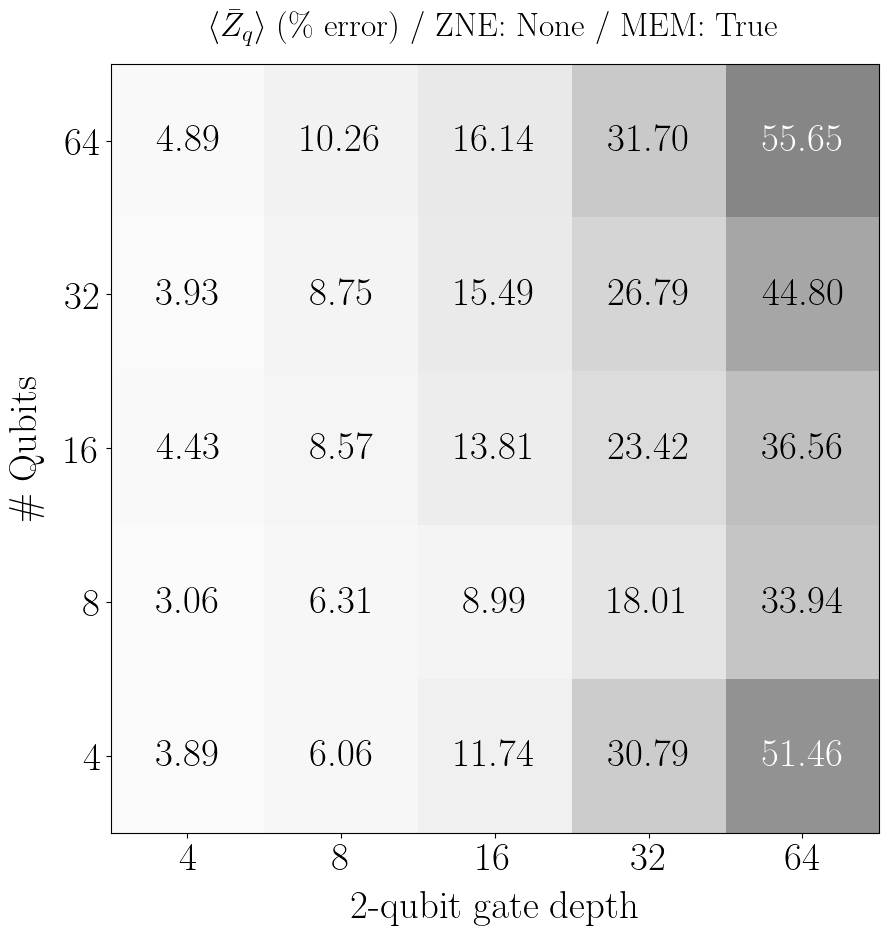

In [21]:
fig, ax = plt.subplots(figsize=[10, 10])
plt.imshow(errors[::-1, :], cmap="Greys", vmin=0, vmax=100)
for i, error in enumerate(errors[::-1].flatten()):
    plt.text(i % errors.shape[0] if errors.shape[0] > 1 else i, i // errors.shape[1], f"{error:.02f}", horizontalalignment="center", verticalalignment="center", color="black" if error < 50 else "white")
plt.xticks(np.arange(errors.shape[1]), twoqdepth_arr)
plt.yticks(np.arange(errors.shape[0]), nqubits_arr[::-1])
plt.xlabel(r"2-qubit gate depth", labelpad=10)
plt.ylabel(r"\# Qubits", labelpad=15)
plt.title(r"$\langle \bar{Z}_q \rangle$  (\% error) / " f"ZNE: {zne_mitigation.title()} / MEM: {measure_mitigation}", pad = 20, fontdict={"size":24})
plt.tight_layout()